# Installations and Imports

In [1]:
!pip install pennylane --upgrade

from IPython.display import clear_output
clear_output(wait=False)

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers


#import tensorflow as tf
#from tensorflow import keras

import pandas as pd
import matplotlib.pyplot as plt

# Importing data files

### npy data files created by the quanvolutional notebook has been imported here. 

In [ ]:
x_train_final = np.load("x_train_final.npy")
y_train = np.load("y_train.npy")

x_test_final = np.load("x_test_final.npy")
y_test = np.load("y_test.npy")

In [ ]:
x_train_final.shape, y_train.shape, x_test_final.shape, y_test.shape

((250, 256), (250,), (65, 256), (65,))

#### train and test data has been concatenated for further size reduction as 256 features are hard to be encoded on a quantum circuit. 

In [ ]:
X = np.concatenate((x_train_final, x_test_final))
Y = np.concatenate((y_train, y_test))
print(X.shape)

(315, 256)


#### from 256 features, 11 feautes has been selected that will be used further.  

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, Y)
model = SelectFromModel(lsvc, prefit=True)
X = model.transform(X)
print(X.shape)



(315, 11)


#### Train and test data has been seperated again. 

In [ ]:
x_train_final = (X[:250])
x_test_final = (X[250:])

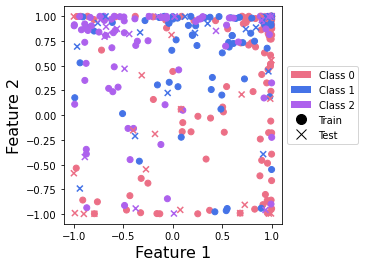

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

colours = ["#ec6f86", "#4573e7", "#ad61ed"]


def plot_points(x_train, y_train, x_test, y_test):
    c_train = []
    c_test = []

    for y in y_train:
        c_train.append(colours[y])

    for y in y_test:
        c_test.append(colours[y])

    plt.scatter(x_train[:, 0], x_train[:, 1], c=c_train)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=c_test, marker="x")

    plt.xlabel("Feature 1", fontsize=16)
    plt.ylabel("Feature 2", fontsize=16)

    ax = plt.gca()
    ax.set_aspect(1)

    c_transparent = "#00000000"

    custom_lines = [
        Patch(facecolor=colours[0], edgecolor=c_transparent, label="Class 0"),
        Patch(facecolor=colours[1], edgecolor=c_transparent, label="Class 1"),
        Patch(facecolor=colours[2], edgecolor=c_transparent, label="Class 2"),
        Line2D([0], [0], marker="o", color=c_transparent, label="Train",
               markerfacecolor="black", markersize=10),
        Line2D([0], [0], marker="x", color=c_transparent, label="Test",
               markerfacecolor="black", markersize=10),
    ]

    ax.legend(handles=custom_lines, bbox_to_anchor=(1.0, 0.75))


plot_points(x_train_final, y_train, x_test_final, y_test)


# Classifier Model description

### In the dataset we have three classses - Covid19, Viral Penumonia and Normal person. 

### Our approach is to divide the classfier in two different models. First model will classify between the classes 'Normal Person' and 'Covid19/Viral Pneumonia'. Second model will classify between the classes 'Covid' and 'Viral Penumonia' 

### First model here is denoted by Model-1 and second one by Model-2. 

# Required functions for classifier model-1

In [ ]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = -2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[2] ** 2 + x[1] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.sqrt(x[2] ** 2 + x[1] ** 2)/np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 ))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

    

In [ ]:
def statepreparation_1(a):

        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        
        qml.RZ(a[0], wires=0)
        qml.RZ(a[1], wires=1)
        qml.CNOT(wires=[0,1])
        qml.RZ(a[0]*a[1], wires=1)
        qml.CNOT(wires=[0,1])

        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        
        qml.RZ(a[1], wires=0)
        qml.RZ(a[2], wires=1)
        qml.CNOT(wires=[0,1])
        qml.RZ(a[1]*a[2], wires=1)
        qml.CNOT(wires=[0,1])
        


        qml.RY(a[0], wires=0)

        qml.CNOT(wires=[0, 1])
        qml.RY(a[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RY(a[2], wires=1)

        for i in range(3,10):
            qml.PauliX(wires=0)
            qml.CNOT(wires=[0, 1])
            qml.RY(a[i], wires=1)
            qml.CNOT(wires=[0, 1])
            qml.RY(a[i+1], wires=1)
            qml.PauliX(wires=0)
        

In [ ]:
def layer_1(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    # qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    
    qml.CNOT(wires=[0, 1])
    # qml.CNOT(wires=[0, 2])
    # qml.CNOT(wires=[1, 2])

In [ ]:
dev_1 = qml.device("default.qubit", wires=2)
@qml.qnode(dev_1)
def circuit_1(weights, x=None):
    # Feature mapping
    # angle = get_angles(x)
    statepreparation_1(x)
    # variational classifier
    for w in weights:
        layer_1(w)
    
    return qml.expval(qml.PauliZ(1))

In [ ]:
def classifier_training_1(params, x=None, y=None):
    weights = params[0]
    bias = params[1]

    out_probs = circuit_1(weights, x=x) + bias
    return (out_probs-y)**2


In [ ]:
def classifier_prediction_1(params, x=None):
    weights = params[0]
    bias = params[1]

    out_probs = circuit_1(weights, x=x) + bias

    
    if(out_probs>0):
        return 1
    else:
        return -1

In [ ]:
def circuit_output_test(params, x=None):
    weights = params[0]
    bias = params[1]

    out_probs = circuit(weights, x=x) + bias

    return out_probs


In [ ]:
 def cost_1(params, X, Y):

    y_pred = np.array([classifier_training_1(params, x=X[i], y=Y[i]) for i in range(len(Y))])

    cost = np.sum(y_pred) / len(Y)
    return cost

In [ ]:
def accuracy_1(params, x_train, y_train, iter):

    y_pred_train = np.array([classifier_prediction_1(params, x=x) for x in x_train])
    acc_train = np.sum(y_pred_train==y_train) / len(y_train)

    print("Iter=> {}   train_cost=> {}   train_acc=> {} ".format(iter+1, cost_1(params, x_train, y_train), acc_train))


# Required functions for classifier model-2

In [ ]:
def statepreparation_2(a):

        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        
        qml.RZ(a[0], wires=0)
        qml.RZ(a[1], wires=1)
        qml.CNOT(wires=[0,1])
        qml.RZ(a[0]*a[1], wires=1)
        qml.CNOT(wires=[0,1])

        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)
        
        qml.RZ(a[1], wires=0)
        qml.RZ(a[2], wires=1)
        qml.CNOT(wires=[0,1])
        qml.RZ(a[1]*a[2], wires=1)
        qml.CNOT(wires=[0,1])
        


        qml.RY(a[0], wires=0)

        qml.CNOT(wires=[0, 1])
        qml.RY(a[1], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.RY(a[2], wires=1)

        for i in range(3,10):
            qml.PauliX(wires=0)
            qml.CNOT(wires=[0, 1])
            qml.RY(a[i], wires=1)
            qml.CNOT(wires=[0, 1])
            qml.RY(a[i+1], wires=1)
            qml.PauliX(wires=0)

In [ ]:
def layer_2(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    # qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    
    qml.CNOT(wires=[0, 1])
    # qml.CNOT(wires=[0, 2])
    # qml.CNOT(wires=[1, 2])

In [ ]:
dev_2 = qml.device("default.qubit", wires=2)
@qml.qnode(dev_2)
def circuit_2(weights, x=None):
    # Feature mapping
    # angle = get_angles(x)
    statepreparation_2(x)
    
    # variational classifier
    for w in weights:
        layer_2(w)
    
    return qml.expval(qml.PauliZ(1))

In [ ]:
def classifier_training_2(params, x=None, y=None):
    weights = params[0]
    bias = params[1]

    out_probs = circuit_2(weights, x=x) + bias
    return (out_probs-y)**2

In [ ]:
def classifier_prediction_2(params, x=None):
    weights = params[0]
    bias = params[1]

    out_probs = circuit_2(weights, x=x) + bias

    
    if(out_probs>0):
        return 1
    else:
        return -1

In [ ]:
def cost_2(params, X, Y):

    y_pred = np.array([classifier_training_2(params, x=X[i], y=Y[i]) for i in range(len(Y))])

    cost = np.sum(y_pred) / len(Y)
    return cost


In [ ]:
def accuracy_2(params, x_train, y_train, iter):

    y_pred_train = np.array([classifier_prediction_2(params, x=x) for x in x_train])
    acc_train = np.sum(y_pred_train==y_train) / len(y_train)

    print("Iter=> {}   train_cost=> {}   train_acc=> {} ".format(iter+1, cost_2(params, x_train, y_train), acc_train))
    

# Model-1

## Data for model-1

0->covid, 1->Normal, 2->Penumonia

#### Here the labels are modified accordinglly for Model-1

In [ ]:
x_train_1 = np.copy(x_train_final)
y_train_1 = []

for i in range(len(y_train)):
    if(y_train[i]==0 or y_train[i]==2):  ##Covid or pneumonia
        y_train_1.append(-1)
    elif(y_train[i]==1):  ##normal person
        y_train_1.append(1)

y_train_1 = np.array(y_train_1)

## Binary Classifier Model-1

In [ ]:
params_1 = (0.01 * np.random.randn(2, 2, 3), 0.0)
params_1

(tensor([[[ 0.00612556, -0.00256142,  0.01053   ],
          [ 0.00216839, -0.01007279, -0.00010648]],
 
         [[-0.00067187, -0.00908299,  0.01408045],
          [-0.00473003,  0.01786172,  0.0066232 ]]], requires_grad=True),
 0.0)

In [ ]:
iters = 50
optimizer_1 = qml.AdagradOptimizer(stepsize=0.5)

for iter in range(iters):
    params_1 = optimizer_1.step(lambda v: cost_1(v, x_train_1, y_train_1), params_1)

    accuracy_1(params_1, x_train_1, y_train_1, iter)

Iter=> 1   train_cost=> 0.9465406671995023   train_acc=> 0.632 
Iter=> 2   train_cost=> 0.9361654379274255   train_acc=> 0.592 
Iter=> 3   train_cost=> 0.9109960710143855   train_acc=> 0.688 
Iter=> 4   train_cost=> 0.8723055581626453   train_acc=> 0.668 
Iter=> 5   train_cost=> 0.8265608613027021   train_acc=> 0.716 
Iter=> 6   train_cost=> 0.8071059298541345   train_acc=> 0.708 
Iter=> 7   train_cost=> 0.7919998495788981   train_acc=> 0.716 
Iter=> 8   train_cost=> 0.787285426404283   train_acc=> 0.72 
Iter=> 9   train_cost=> 0.799059532754528   train_acc=> 0.696 
Iter=> 10   train_cost=> 0.7965355634919986   train_acc=> 0.692 
Iter=> 11   train_cost=> 0.7815100773128374   train_acc=> 0.7 
Iter=> 12   train_cost=> 0.7762165565636774   train_acc=> 0.692 
Iter=> 13   train_cost=> 0.7699521378398912   train_acc=> 0.704 
Iter=> 14   train_cost=> 0.7682762621989432   train_acc=> 0.692 
Iter=> 15   train_cost=> 0.7661915962405126   train_acc=> 0.708 
Iter=> 16   train_cost=> 0.765753622509

# Model-2

## Data for model-2
0->covid, 1->Normal, 2->Penumonia

#### Here the labels are modified accordingly for Model-2

In [ ]:
x_train_2 = []
y_train_2 = []

for i in range(len(y_train)):
    if(y_train[i]==0):   ## covid
        x_train_2.append(x_train_final[i])
        y_train_2.append(1)
    elif(y_train[i]==2):  ## pneumonia
        x_train_2.append(x_train_final[i])
        y_train_2.append(-1)


x_train_2 = np.array(x_train_2)
y_train_2 = np.array(y_train_2)

## Binary Classifier Model-2

In [ ]:
params_2 = (0.01 * np.random.randn(2, 2, 3), 0.0)
params_2

(tensor([[[-1.34841542e-02,  1.49424421e-02,  5.76354377e-03],
          [-3.02078872e-03, -2.15117350e-03, -6.71429076e-05]],
 
         [[-1.59254516e-02, -2.14154692e-02, -6.90493502e-04],
          [ 1.00902741e-02,  4.79889995e-03,  9.38148572e-03]]], requires_grad=True),
 0.0)

In [ ]:
iters = 50
optimizer_2 = qml.AdagradOptimizer(stepsize=0.5)

for iter in range(iters):
    params_2 = optimizer_2.step(lambda v: cost_2(v, x_train_2, y_train_2), params_2)

    accuracy_2(params_2, x_train_2, y_train_2, iter)

Iter=> 1   train_cost=> 1.2554225181150627   train_acc=> 0.5111111111111111 
Iter=> 2   train_cost=> 0.9439350950299421   train_acc=> 0.5944444444444444 
Iter=> 3   train_cost=> 1.0105179591527453   train_acc=> 0.6277777777777778 
Iter=> 4   train_cost=> 1.0076856369893235   train_acc=> 0.6222222222222222 
Iter=> 5   train_cost=> 0.8715373168316767   train_acc=> 0.6722222222222223 
Iter=> 6   train_cost=> 0.8220362427490671   train_acc=> 0.6833333333333333 
Iter=> 7   train_cost=> 0.7984506078500819   train_acc=> 0.6833333333333333 
Iter=> 8   train_cost=> 0.779958754571459   train_acc=> 0.7222222222222222 
Iter=> 9   train_cost=> 0.7670961941947209   train_acc=> 0.7333333333333333 
Iter=> 10   train_cost=> 0.7556347836796031   train_acc=> 0.7 
Iter=> 11   train_cost=> 0.7477561795166506   train_acc=> 0.7333333333333333 
Iter=> 12   train_cost=> 0.7409869933343458   train_acc=> 0.7333333333333333 
Iter=> 13   train_cost=> 0.735491109980575   train_acc=> 0.7277777777777777 
Iter=> 14   

# Prediction

### While Predicting, we first give input to the Model-1. If it predicts as Normal person, then it is the final prediction assigned to the input. If not, then we give the same input to Model-2 and it finally predicts whether the chest x-ray is Covid10 patient or Viral Pneumonia patient. 

In [ ]:
y_pred = []

for i in range(len(x_test_final)):
    tmp = classifier_prediction_1(params_1, x=x_test_final[i])
    if (tmp == 1):  ## Normal person
        y_pred.append(1)
    else:   ## Covid or Pneumonia
        tmp = classifier_prediction_2(params_2, x=x_test_final[i])
        if(tmp == 1):  ## covid
            y_pred.append(0)
        elif(tmp == -1): ## Pneumonia
            y_pred.append(2)

y_pred = np.array(y_pred)

In [ ]:
print("Final_Test_Accuracy => ", np.sum(y_pred==y_test)/len(y_test))

Final_Test_Accuracy =>  0.5230769230769231


### We are hopeful to in increment in this accuracy when it will be trained on real computer with larger dataset. 